# Sentiment Analysis Using RNN

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.data.path.append(r'C:\Users\Vignesh P\nltk_data')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import joblib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Retheck\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Retheck\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Retheck\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Retheck\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
!pip install keras


# Load the training data

In [2]:
train_data = pd.read_csv("C:\\Users\\Retheck\\Downloads\\tweets_train.csv")

In [3]:
train_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text,Sentiment
0,Romy 👑,Bolton - England,"Tables turn, bridges burn, you live and learn.",2009-06-15 09:00:39,525,896,3854,False,2020-09-19 15:19:32,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TLynn Peterson,"Black Canyon City, Arizona",Acquired disability ♿ after an accident. Livin...,2013-05-29 00:17:46,5045,5374,48152,False,2020-09-13 00:31:46,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma If we don t agree on what is ...,Positive
2,Rutger Kosters,Netherlands,Cloud Solution Architect @NetApp | VCDX #209 |...,2014-10-07 09:34:10,574,251,1070,False,2020-09-09 21:10:33,['TheSocialDilemma'],Twitter for Android,False,Watching TheSocialDilemma scary to see social ...,Negative
3,IDFWU🗯🇿🇼🇿🇦,"East London, South Africa","YOU HAVE OPTIONS, YOU CAN’T JUST TAKE WHAT LIF...",2012-08-22 11:09:06,706,618,1320,False,2020-09-11 04:33:08,NaN,Twitter for Android,False,You check your social media before you pee in ...,Positive
4,Treebel,NaN,NaN,2010-09-25 07:25:31,9,13,55,False,2020-09-17 16:27:38,['thesocialdilemma'],Twitter for iPhone,False,watch thesocialdilemma and see what s actually...,Negative


# Preprocessing Function

In [14]:
def preprocess_data(data, max_words=10000, max_sequence_length=100, save_tokenizer=False, tokenizer_path=None, single_tweet = False):
    if single_tweet:
        tweets = pd.DataFrame({'clean_text': [single_tweet]})

    else:
        # Handle null values
        data.dropna(subset=['clean_text'], inplace=True)

        # Handling duplicates
        data.drop_duplicates(subset=['clean_text'], inplace=True)

        # Preprocessing for text data
        tweets = data['clean_text']

    # Lemmatization and removing stopwords to sequences
    processed_sequences = []
    for tweet in tweets:
        tokens = word_tokenize(tweet)  # Tokenize the tweet into words
        processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token.lower() not in stop_words]
        processed_sequences.append(processed_tokens)

    # Converting sequences to sequences of indices using the tokenizer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts([' '.join(seq) for seq in processed_sequences])
    sequences = tokenizer.texts_to_sequences([' '.join(seq) for seq in processed_sequences])

    # Saving tokenizer if specified
    if save_tokenizer and tokenizer_path:
        joblib.dump(tokenizer, tokenizer_path)

    # Padding sequences to a fixed length
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    return padded_sequences

In [15]:
# Applying Pre Processing Function on Training Data

x_train = preprocess_data(train_data, save_tokenizer=True, tokenizer_path="tokenizer.pkl")

In [17]:
x_train

array([[   0,    0,    0, ..., 1412,   43,  152],
       [   0,    0,    0, ...,   26,  108, 1413],
       [   0,    0,    0, ...,  482,  859, 1335],
       ...,
       [   0,    0,    0, ...,    1,   90,   23],
       [   0,    0,    0, ...,    5,   91,   72],
       [   0,    0,    0, ...,    1,  348,   19]])

In [18]:
sentiments_map = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
labels = np.array([sentiments_map[i] for i in train_data['Sentiment']])

In [19]:
labels

array([1, 0, 2, ..., 1, 0, 2])

# Splitting the Dataset

In [20]:
X_train, X_val, y_train, y_val = train_test_split(x_train, labels, test_size=0.2, random_state=42)

# Builing the RNN Model

In [21]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(SimpleRNN(units=128))
model.add(Dense(units=3, activation='softmax'))

In [22]:
# Model Compilation

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Train the model

batch_size = 32
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.5328 - loss: 1.0045 - val_accuracy: 0.7392 - val_loss: 0.6485
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8247 - loss: 0.4590 - val_accuracy: 0.8217 - val_loss: 0.4832
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9430 - loss: 0.1844 - val_accuracy: 0.8310 - val_loss: 0.5272
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9769 - loss: 0.0827 - val_accuracy: 0.8360 - val_loss: 0.5823
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9920 - loss: 0.0364 - val_accuracy: 0.8319 - val_loss: 0.6609
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9256 - loss: 0.2056 - val_accuracy: 0.7880 - val_loss: 0.6189
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8940 - loss: 0.2871 - val_accuracy: 0.8313 - val_loss: 0.5488
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9453 - loss: 0.1588 - 

# Evaluation on Training Data

In [24]:
# Evaluating the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size)

# Evaluating the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, batch_size=batch_size)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

402/402 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9883 - loss: 0.0440
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8433 - loss: 0.6266
Training Loss: 0.04247172921895981
Training Accuracy: 0.9895719885826111
Validation Loss: 0.6184977889060974
Validation Accuracy: 0.8446934223175049


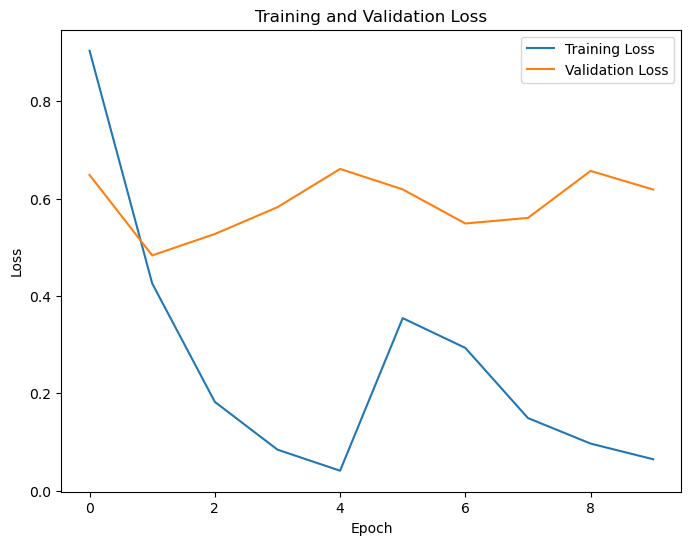

In [25]:
# Plot training and validation loss

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

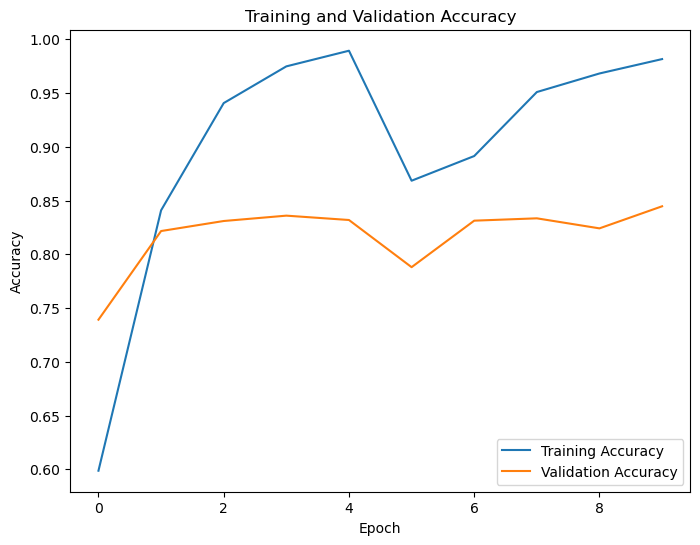

In [26]:
# Plot for the training and validation accuracy

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#  Loading the Test Data

In [27]:
test_data = pd.read_csv("C:\\Users\\Retheck\\Downloads\\tweets_test.csv")

# Preprocessing the Test Data

In [28]:
tokenizer = joblib.load("tokenizer.pkl")
x_test = preprocess_data(test_data, save_tokenizer=True, tokenizer_path="tokenizer.pkl")

# Predicting the Test Data

In [29]:
predicted_probabilities = model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


# Predicting the Future Tweets..!

In [30]:
def predict_sentiment(tweet, model, tokenizer):
    #PreProcessing the tweet
    processed_tweet = preprocess_data(tweet, save_tokenizer=True, tokenizer_path="tokenizer.pkl", single_tweet = True)

    # Predict sentiment probabilities
    predicted_probabilities = model.predict(processed_tweet)

    # Convert probabilities to sentiment label
    sentiment_mapping_reverse = {0: 'Positive', 1: 'Neutral', 2: 'Negative'}
    predicted_class = np.argmax(predicted_probabilities, axis=1)[0]
    predicted_sentiment = sentiment_mapping_reverse[predicted_class]

    return predicted_sentiment

In [32]:
synthetic_tweet = "Justice for all. Stand up and speak out. #BlackLivesMatter"
predicted_sentiment = predict_sentiment(synthetic_tweet, model, tokenizer)

print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Sentiment: Neutral
